In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import matplotlib
import time

In [20]:
from utils import load_data
from utils import preprocess_pipeline

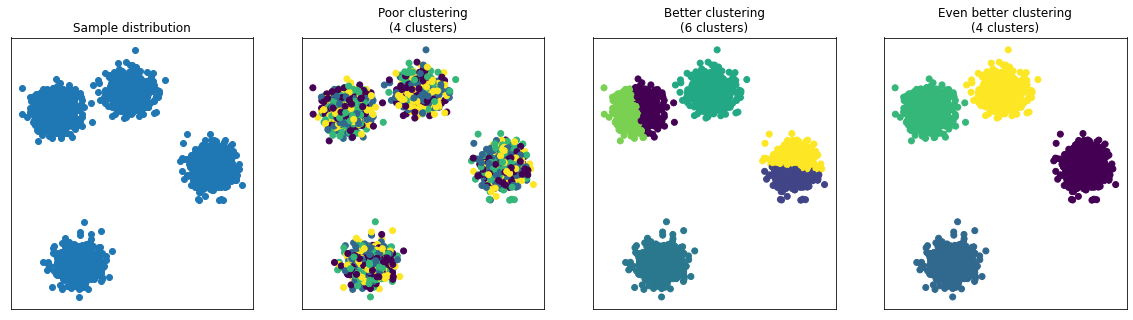

In [21]:
n_samples = 2000
random_state = 42
X, y = make_blobs(n_samples=n_samples, centers= 4, random_state=random_state)

plt.figure(figsize=(20, 5))

plt.subplot(141)
plt.title("Sample distribution")
ax = plt.scatter(X[:, 0], X[:, 1])
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(142)
plt.title("Poor clustering\n(4 clusters)")
ax = plt.scatter(X[:, 0], X[:, 1], c=np.random.randint(size=(n_samples,), low=0, high=4))
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(143)
plt.title("Better clustering\n(6 clusters)")
y_pred = KMeans(n_clusters=6, random_state=random_state).fit_predict(X)
ax = plt.scatter(X[:, 0], X[:, 1], c=y_pred)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.subplot(144)
plt.title("Even better clustering\n(4 clusters)")
y_pred = KMeans(n_clusters=4, random_state=random_state).fit_predict(X)
ax = plt.scatter(X[:, 0], X[:, 1], c=y_pred)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

plt.savefig("part-2-images/clustering-101.jpg", dpi=100)
plt.show()

## Load corpus

In [6]:
corpus = load_data("my-dataset/")

In [7]:
corpus.shape

(1904, 9)

In [8]:
documents = corpus['selftext'].tolist()

In [9]:
print(documents[0])

New Years' Eve. And I'm working tonight. It's always the worst night of the year for us. Tonight is when the monsters come out. They've been with us for as long as we can remember now. 

They're always around, but it is New Years' Eve on which they get worse. Something seems to get into people. They're drawn to the monsters. We try to fight them, try to get the people to safety, tend to their injuries. Every year, hundreds of people get maimed, injured. Some even die. Not so many anymore, we've learnt how to deal with the evil that lurks in our world.

I watch the clock tick towards the inevitable start of the chaos, of the attacks. My tools are near me and I check them once again. Everything's there. Ready. Only a few minutes left now. I move to the canteen, to my brothers and sisters in arms. We're all ready for tonight's battle. While the minutes count down we wait, anxious for both the new year and the task that lays ahead of us.

The monsters are outside, waiting. Waiting to be re

## Preprocess documents

In [12]:
start = time.time()
preprocessed_documents = [preprocess_pipeline(s) for s in documents]
print(f"Preprocessing time: {time.time()-start:.1f}s.")

Preprocessing time: 0.9s.


In [13]:
print(preprocessed_documents[0])

new years' eve and i'm working tonight it's always the worst night of the year for us tonight is when the monsters come out they've been with us for as long as we can remember now they're always around but it is new years' eve on which they get worse something seems to get into people they're drawn to the monsters we try to fight them try to get the people to safety tend to their injuries every year hundreds of people get maimed injured some even die not so many anymore we've learnt how to deal with the evil that lurks in our world i watch the clock tick towards the inevitable start of the chaos of the attacks my tools are near me and i check them once again everything's there ready only a few minutes left now i move to the canteen to my brothers and sisters in arms we're all ready for tonight's battle while the minutes count down we wait anxious for both the new year and the task that lays ahead of us the monsters are outside waiting waiting to be released by the striking of the clock

## Vectorize with frequency counts

In [22]:
tf_vectorizer = CountVectorizer(max_df=0.80, min_df=10, stop_words=stopwords.words('english')+['like', 'said', 'could', 'would', 'one', 'know', 'us'], max_features=1000)

In [23]:
tf = tf_vectorizer.fit_transform(preprocessed_documents).toarray()

In [24]:
features = tf_vectorizer.get_feature_names_out()

In [25]:
tf.shape

(1904, 1000)

In [26]:
len(features)

1000

## Topic modelling with LDA

In [27]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [28]:
from utils import print_topics, get_topics_top_words

In [29]:
n_topics = 10

In [104]:
model = LDA(n_components=n_topics, random_state=0)

In [105]:
doc_topic = model.fit_transform(tf)

# K-Means Clustering

In [106]:
from sklearn.cluster import KMeans

C = 10
random_state = 42
clusterer = KMeans(n_clusters=C, random_state=random_state)
cluster_labels = clusterer.fit_predict(doc_topic)

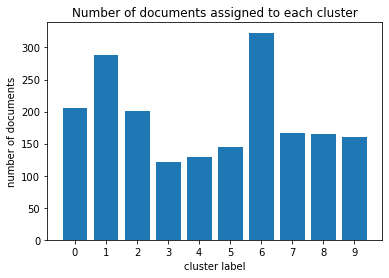

In [107]:
x, y = np.unique(cluster_labels, return_counts=True)
plt.bar(x, y)
plt.xticks(range(C), range(C))
plt.title("Number of documents assigned to each cluster")
plt.xlabel("cluster label")
plt.ylabel("number of documents")
plt.show()

In [108]:
from sklearn import metrics

def plot_cluster_metrics(data, min_clusters=2, max_clusters=20, iters=10):
    n_clusters = []

    wgss_mean = [] # within group sum of squares, or inertia
    wgss_var = [] # variance of results because it's stochastic

    silhouette_mean = []
    silhouette_var = []
    
    for n in range(min_clusters, max_clusters+1):
        n_clusters.append(n)

        wgss_iters = []
        silhouette_iters = []

        for i in range(iters):
            clusterer = KMeans(n_clusters=n).fit(data)
            wgss_iters.append(clusterer.inertia_)
            silhouette_iters.append(metrics.silhouette_score(data,
                                                             clusterer.labels_,
                                                             metric='euclidean'))

        wgss_mean.append(np.array(wgss_iters).mean())
        wgss_var.append(np.array(wgss_iters).var())

        silhouette_mean.append(np.array(silhouette_iters).mean())
        silhouette_var.append(np.array(silhouette_iters).var())

    wgss_mean = np.array(wgss_mean)
    wgss_var = np.array(wgss_var)

    silhouette_mean = np.array(silhouette_mean)
    silhouette_var = np.array(silhouette_var)
    
    # plot every metric
    plt.figure(figsize=(10, 10))
    
    plt.subplot(211)
    plt.xticks(n_clusters)
    plt.plot(n_clusters, silhouette_mean, alpha=1, color='red', label='silhouette')
    plt.fill_between(n_clusters,
                     silhouette_mean-silhouette_var,
                     silhouette_mean+silhouette_var,
                     alpha=0.2)
    plt.title("Evaluate quality of clusters")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(212)
    plt.xticks(n_clusters)
    plt.plot(n_clusters, wgss_mean, alpha=1, label='inertia', color='orange')
    plt.fill_between(n_clusters, wgss_mean-wgss_var, wgss_mean+wgss_var, alpha=0.2)
    plt.xlabel("# clusters")
    plt.legend()
    plt.grid(True)
    
    plt.savefig("part-2-images/clustering-metrics.jpg", dpi=100)
    plt.show()
    return

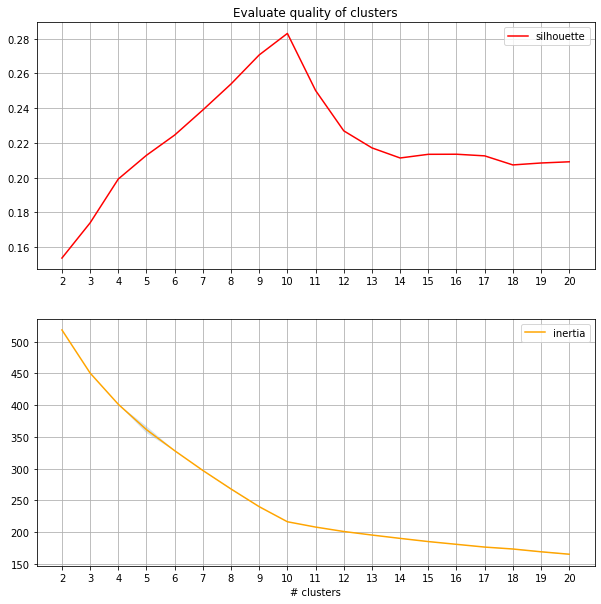

In [109]:
plot_cluster_metrics(doc_topic)

In [110]:
# adapted from: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_
# silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

def plot_cluster_silhouette(data, n_clusters, cluster_labels):
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = metrics.silhouette_score(data, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = metrics.silhouette_samples(data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0,
                          ith_cluster_silhouette_values,
                          facecolor=color,
                          edgecolor=color,
                          alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_xlabel("silhouette coefficient values")
    ax1.set_ylabel("cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Clustering on sample data with # clusters = "
                  + str(n_clusters) + "\nAverage silhouette_score is : "
                  + str(silhouette_avg)))
    
    plt.savefig("part-2-images/clustering-silhouette.jpg", dpi=100)
    plt.show()

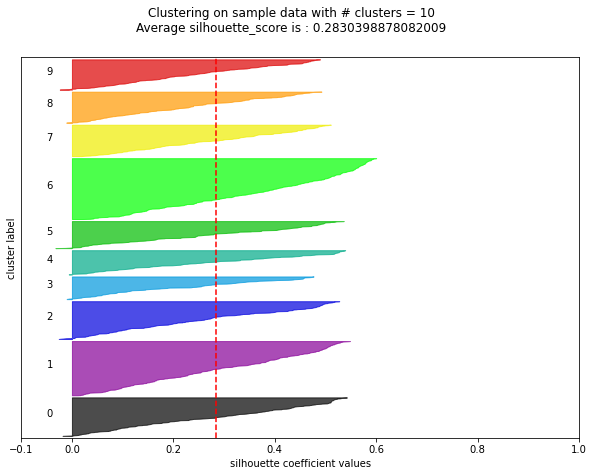

In [113]:
C = 10
clusterer = KMeans(n_clusters=C, random_state=random_state)
cluster_labels = clusterer.fit_predict(doc_topic)

plot_cluster_silhouette(doc_topic, C, cluster_labels)

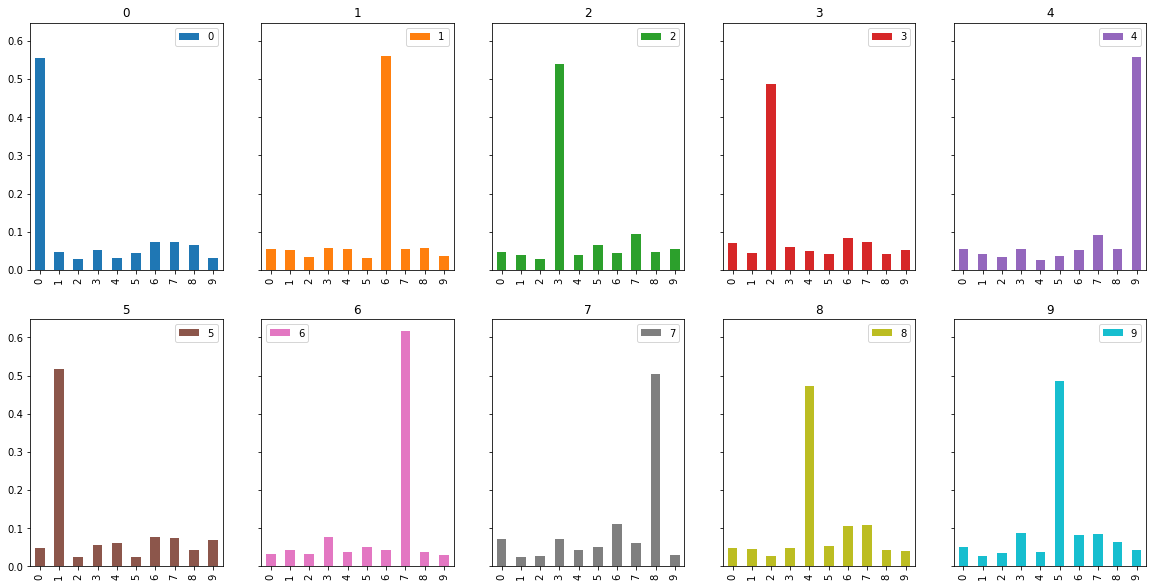

In [117]:
import pandas as pd

doc_topic_df = pd.DataFrame(doc_topic)
doc_topic_df.groupby(cluster_labels).mean().transpose().plot.bar(layout=(2,5), figsize=(20,10), subplots=True, sharey=True, sharex=False)
plt.savefig("part-2-images/clustering-meaning.jpg", dpi=100)
plt.show()